In [45]:
import pandas as pd
from pathlib import Path
import os
import seaborn as sns
import matplotlib as plt
import numpy as np
import statsmodels.stats.multitest
from statsmodels.stats.multitest import multipletests

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 80 # 200 e.g. is really fine, but slower

font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# get fGWAS results

In [46]:
gwas=pd.read_csv('/home/jovyan/data/fGWAS_v_LDSC/fetal_heart_all_results_22Oct22_with_efo_ids.csv',index_col='Study')
gwas['Celltype_fGWAS']=gwas['Celltype']
gwas=gwas.drop(['Celltype'],axis=1)
gwas

,logOR,FDR,Pvalue,efo_id,trait,Celltype_fGWAS
Study,,,,,,
GCST90043969,-0.047036,0.999975,0.999975,EFO_0000318,cardiomyopathy,AtrialCardiomyocytesCycling
GCST90043969,-0.170451,0.999975,0.999887,EFO_0000318,cardiomyopathy,AtrialCardiomyocytesLeft
GCST90043969,-0.194440,0.999975,0.999897,EFO_0000318,cardiomyopathy,AtrialCardiomyocytesRight
GCST90043969,-0.125184,0.999975,0.999905,EFO_0000318,cardiomyopathy,AtrioventricularNodeCardiomyocytes
GCST90043969,-0.299092,0.999975,0.999781,EFO_0000318,cardiomyopathy,BCells
...,...,...,...,...,...,...
GCST90080016,1.778650,0.790931,0.334281,EFO_0009276,ventricular ectopy,VentricularCardiomyocytesCycling
GCST90080016,1.366725,0.790931,0.355875,EFO_0009276,ventricular ectopy,VentricularCardiomyocytesPRRX1pos
GCST90080016,1.373514,0.790931,0.307946,EFO_0009276,ventricular ectopy,VentricularCardiomyocytesTrabeculated


Celltype_fGWAS,AtrialCardiomyocytesCycling,AtrialCardiomyocytesLeft,AtrialCardiomyocytesRight,AtrioventricularNodeCardiomyocytes,BCells,Cardiofibromyocytes,ChromaffinCells,CoronaryEndothelialCellsArterial,CoronaryEndothelialCellsCapillary,CoronaryEndothelialCellsVenous,...,SympatheticNeurons,TCells,ValvalEndothelialCells,ValveInterstitialCells,VentricularCardiomyocytesCompact,VentricularCardiomyocytesCycling,VentricularCardiomyocytesPRRX1pos,VentricularCardiomyocytesTrabeculated,VentricularConductionSystemDistal,VentricularConductionSystemProximal
trait,,,,,,,,,,,,,,,,,,,,,
Brugada syndrome,0.0,3.483758,3.268657,1.396615,0.0,3.362784,0.235242,2.431328,2.182528,2.3807,...,0.278188,0.0,0.0,0.533256,4.752175,4.334795,4.650381,3.869974,2.044871,4.232305
Mitral valve prolapse,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
acute myocardial infarction,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
aortic valve disease,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
aortic valve insufficiency,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


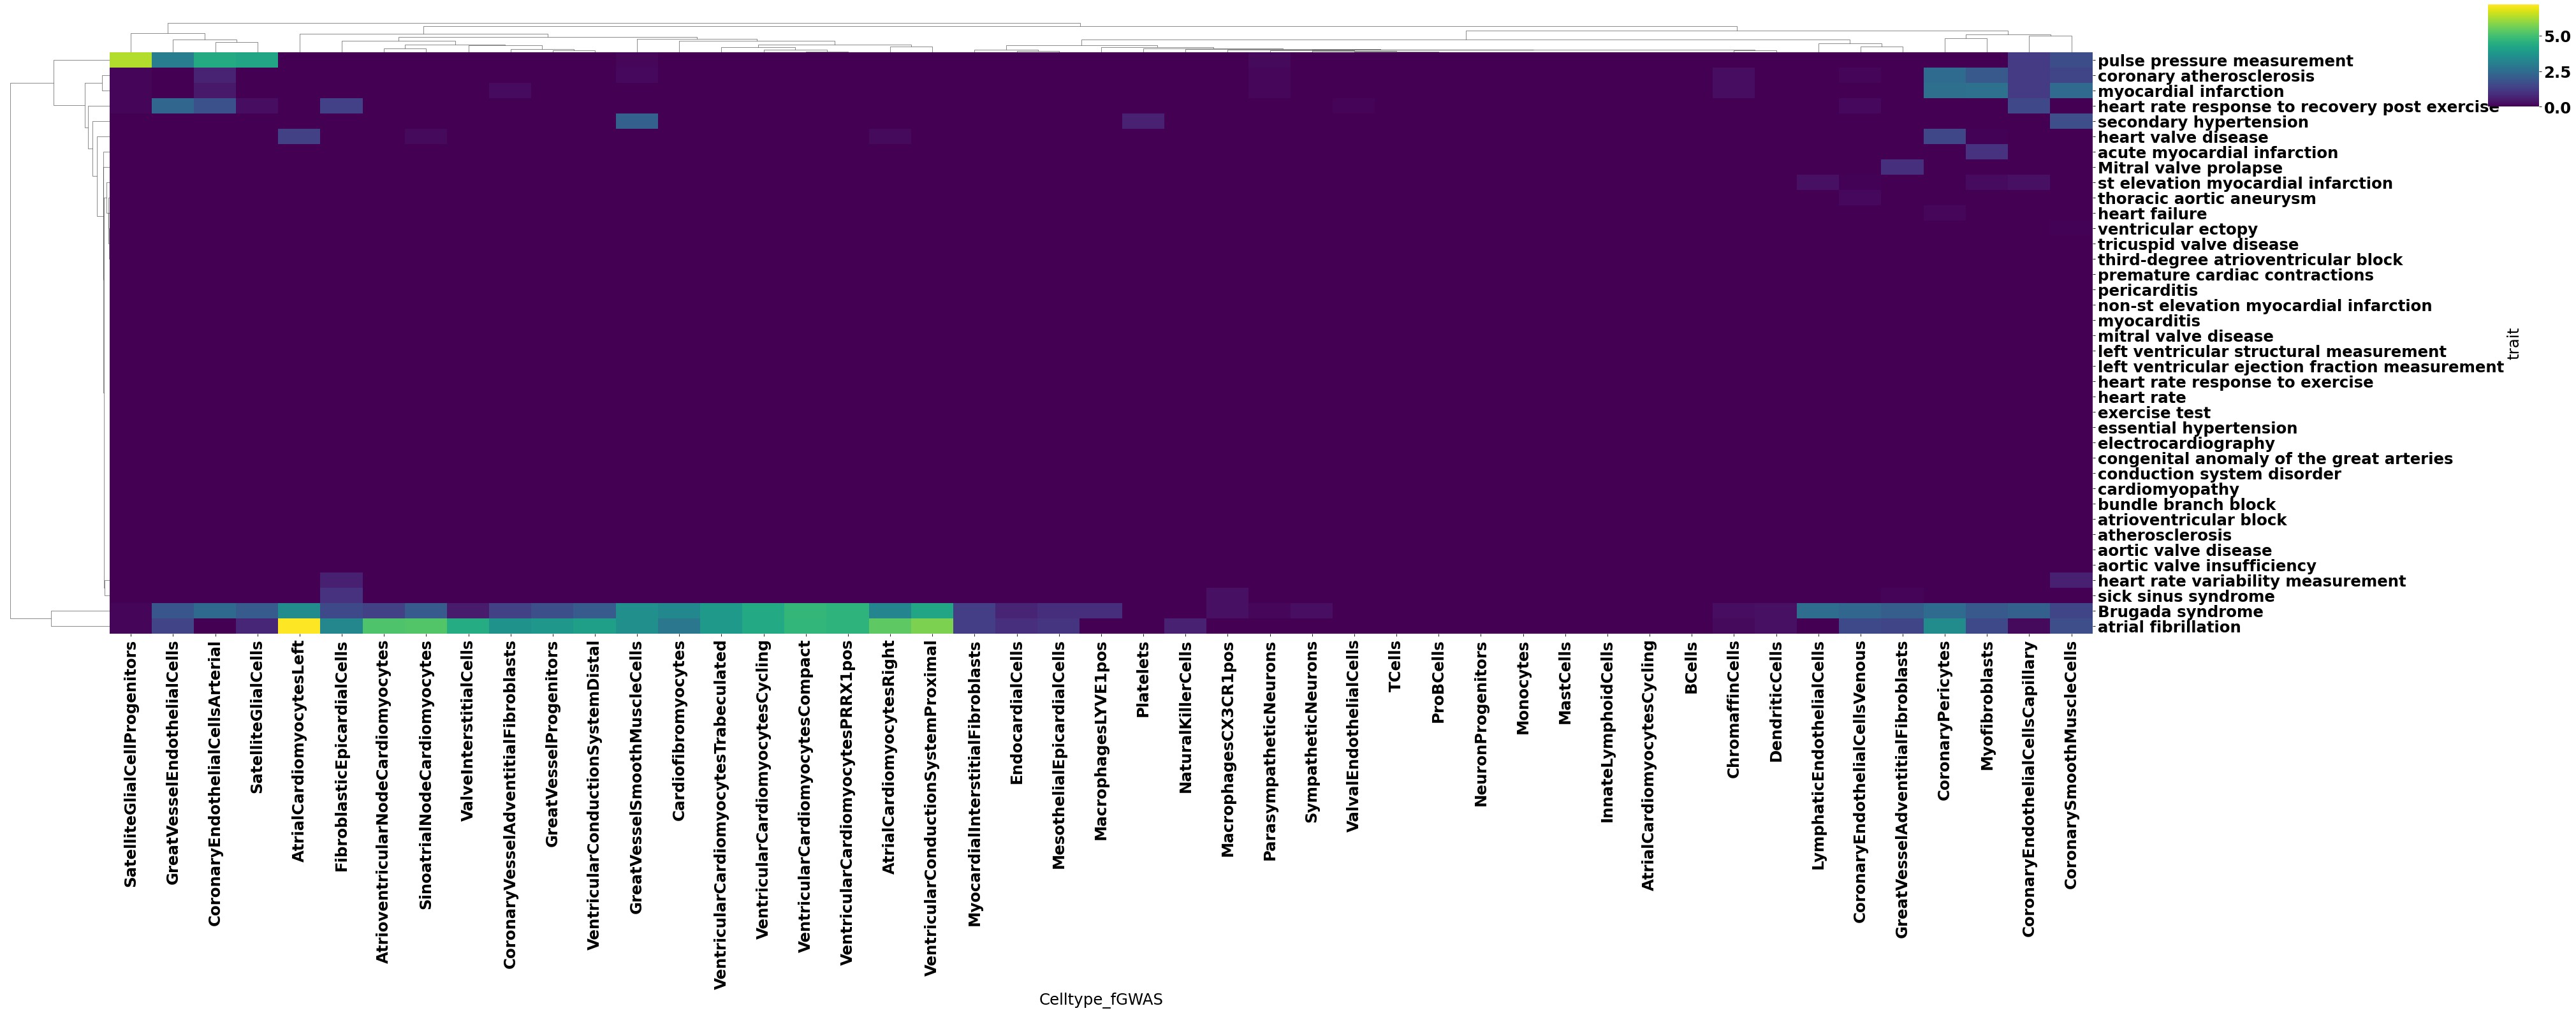

In [47]:
#pivot the table to prepare for heatmap
df=gwas.pivot_table(index='trait', columns='Celltype_fGWAS', values='Pvalue')

# MT-correct
method='fdr_bh'
columns=df.columns.tolist()

# correct for multiple testing (each test being one cell type)
for column in columns:
    df[column]=statsmodels.stats.multitest.multipletests(df[column],method=method)[1]

# neg-log transform
df=np.negative(np.log10(df))
df[df == -0] = 0 # replace '-0' with '0'
df.replace(to_replace=[np.inf, -np.inf], value='inf', inplace=True) # replace infinities with something sensible (the maximum real number found elsewhere in the df)
df.replace(to_replace='inf', value=df.max().max(), inplace=True)

# plot
sns.clustermap(df,
               xticklabels=True,
               yticklabels=True,
               cmap='viridis',
               figsize=(50,20),
               dendrogram_ratio=0.05,
               cbar_pos=(0.98,0.9,0.02,0.1),)

df.head()

# get LDSC results

In [48]:
gwas_df = pd.read_csv(
    '/lustre/scratch126/cellgen/team205/sl37/cardio_ldsc/public_data/CV_trait_studies_filtered_2022-10-08.csv')
print(gwas_df.shape)
gwas_df.head(1)

(221, 23)


,study_id,reported_trait,initial_sample_size,replication_sample_size,gxe,gxg,snp_count,qualifier,imputed,pooled,...,type,number_of_individuals,pubmed_id,publication_date,author_fullname,publication,ancestral_group,EFO_id,EFO_term,accessed
0,GCST90134593,Right ventricular end systolic volume (MTAG),"29,498 European ancestry individuals","12,321 European ancestry individuals",0,0,7158086,NaN,1,-2147483648,...,initial,29498,35697868,13/06/2022,Aung N,Nat Genet,European,EFO_0021815,right ventricular systolic volume measurement,08/10/2022


In [49]:
processed_dir = Path("/lustre/scratch126/cellgen/team205/sl37/cardio_ldsc/public_data/ldsc_input/ready_to_use")
harmonised_studies = [x.split('.')[0].split('_')[1] for x in os.listdir(processed_dir) if x.endswith('_b38.tsv.gz')]
processed_studies = [x.split('.')[0].split('_')[1] for x in os.listdir(processed_dir) if x.endswith('sumstats.gz')]

In [50]:
gwas_df[~gwas_df['study_id'].isin(harmonised_studies)].shape, gwas_df[~gwas_df['study_id'].isin(processed_studies)].shape

((97, 23), (110, 23))

In [51]:
gwas_df[(~gwas_df['study_id'].isin(processed_studies)) & (gwas_df['study_id'].isin(harmonised_studies))][['pubmed_id', 'study_id']]

,pubmed_id,study_id
176,33772158,GCST90013538
177,32915819,GCST90012187
178,32915819,GCST90012182
179,32915819,GCST90012178
180,32915819,GCST90012176
181,32915819,GCST90012175
182,32915819,GCST90012174
185,32814899,GCST90000296
196,33230300,GCST90000060
197,33619380,GCST011330


In [52]:
gwas_df[~gwas_df['study_id'].isin(harmonised_studies)]['pubmed_id'].value_counts()

34662886    68
33893285     5
35240056     3
35697868     3
30940143     2
30525989     2
34737426     2
30104761     1
30012220     1
32887874     1
29695241     1
30535219     1
35479509     1
32439900     1
30586722     1
30003307     1
30224653     1
32382064     1
32916098     1
Name: pubmed_id, dtype: int64

In [53]:
gwas_dic = gwas_df[['study_id', 'reported_trait']].set_index('study_id')['reported_trait'].T.to_dict()

In [54]:
res_dir = Path("/lustre/scratch126/cellgen/team205/sl37/cardio_ldsc/ldsc_out_withbackground")
sig_res_concated_df = pd.DataFrame()
for filename in os.listdir(res_dir):
    if filename.endswith('cell_type_results.txt'):
        df = pd.read_csv(res_dir/filename, sep='\t', index_col=0)
        df['p_corrected'] = [(min(1, x*df.shape[0])) for x in df['Coefficient_P_value']]
        df['trait'] = gwas_dic.get(filename.split('.')[0].split('_')[1])
        df['study'] = filename.split('_')[1].split('.')[0]
        sig_df = df[df['p_corrected']<0.05]
        if sig_df.shape[0] > 1:
#            print(filename)
#            print(sig_df[['Coefficient_P_value']])
#            print('\n')
            sig_res_concated_df = pd.concat([sig_res_concated_df,
                                             df],
                                           axis=0)

In [55]:
sig_res_concated_df['CellType_LDSC']=sig_res_concated_df.index
sig_res_concated_df.set_index(['study'],inplace=True)
sig_res_concated_df.head(3)

,Coefficient,Coefficient_std_error,Coefficient_P_value,p_corrected,trait,CellType_LDSC
study,,,,,,
GCST005850,4.915986e-07,1.557809e-07,0.000801,0.036025,Heart rate response to recovery post exercise ...,NeuronProgenitors-reproduciblePeaks
GCST005850,4.798451e-07,1.565605e-07,0.001089,0.048989,Heart rate response to recovery post exercise ...,SympatheticNeurons-reproduciblePeaks
GCST005850,3.074226e-07,1.077773e-07,0.002170,0.097632,Heart rate response to recovery post exercise ...,SinoatrialNodeCardiomyocytes-reproduciblePeaks


CellType_LDSC,AtrialCardiomyocytesLeft-reproduciblePeaks,AtrialCardiomyocytesRight-reproduciblePeaks,AtrioventricularNodeCardiomyocytes-reproduciblePeaks,BCells-reproduciblePeaks,Cardiofibromyocytes-reproduciblePeaks,ChromaffinCells-reproduciblePeaks,CoronaryEndothelialCellsArterial-reproduciblePeaks,CoronaryEndothelialCellsCapillary-reproduciblePeaks,CoronaryEndothelialCellsVenous-reproduciblePeaks,CoronaryPericytes-reproduciblePeaks,...,SinoatrialNodeCardiomyocytes-reproduciblePeaks,SympatheticNeurons-reproduciblePeaks,ValvalEndothelialCells-reproduciblePeaks,ValveInterstitialCells-reproduciblePeaks,VentricularCardiomyocytesCompact-reproduciblePeaks,VentricularCardiomyocytesCycling-reproduciblePeaks,VentricularCardiomyocytesPRRX1pos-reproduciblePeaks,VentricularCardiomyocytesTrabeculated-reproduciblePeaks,VentricularConductionSystemDistal-reproduciblePeaks,VentricularConductionSystemProximal-reproduciblePeaks
trait,,,,,,,,,,,,,,,,,,,,,
Atrial fibrillation,2.499783,3.048566,1.104299,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,1.959289,0.000000,0.0,0.0,1.899369,4.359495,1.021144,1.611689,2.237356,1.386085
Atrial fibrillation and flutter (PheCode 427.2),1.897010,2.495753,0.769697,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.980879,0.000000,0.0,0.0,0.988527,2.980654,0.766715,0.348585,0.497149,1.023605
Brugada syndrome,0.684911,1.281669,1.074417,0.0,1.773880,0.0,0.000000,0.000000,0.0,0.000000,...,0.439867,0.000000,0.0,0.0,3.238785,2.300265,3.687112,2.673151,0.888626,2.716243
Coronary atherosclerosis (PheCode 411.4),0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.730084,1.590582,0.0,1.852839,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Heart rate response to recovery post exercise (30 sec),0.000000,0.023524,0.000000,0.0,0.295964,0.0,0.000000,0.000000,0.0,0.000000,...,1.010406,1.309899,0.0,0.0,0.000000,0.035163,0.000000,0.000000,0.000000,0.344035


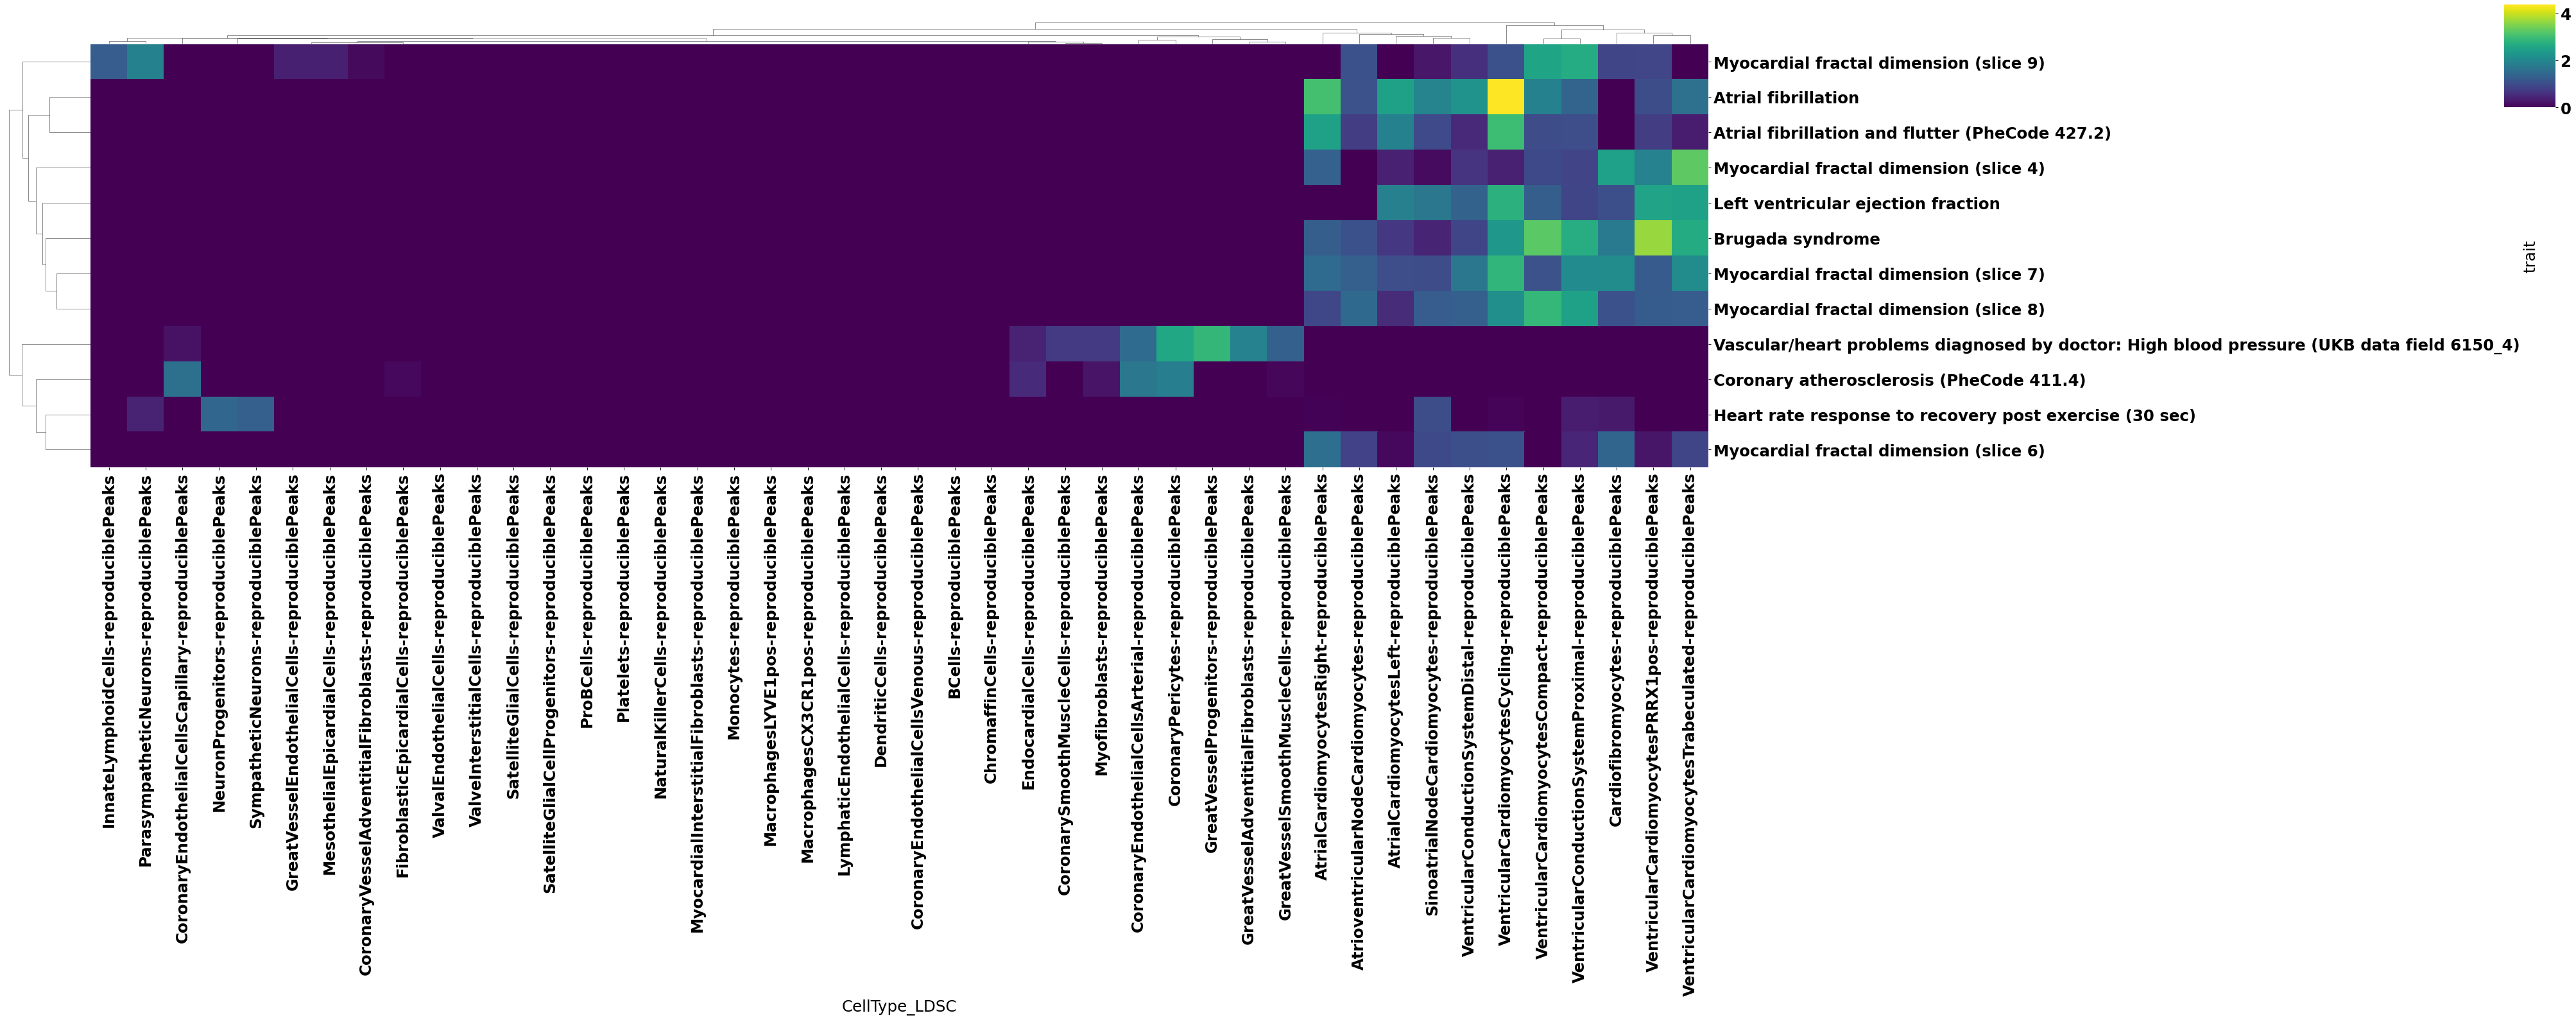

In [56]:
#pivot the table to prepare for heatmap
df=sig_res_concated_df.pivot_table(index='trait', columns='CellType_LDSC', values='p_corrected')

# neg-log transform
df=np.negative(np.log10(df))
df[df == -0] = 0 # replace '-0' with '0'
df.replace(to_replace=[np.inf, -np.inf], value='inf', inplace=True) # replace infinities with something sensible (the maximum real number found elsewhere in the df)
df.replace(to_replace='inf', value=df.max().max(), inplace=True)

# plot
sns.clustermap(df,
               xticklabels=True,
               yticklabels=True,
               cmap='viridis',
               figsize=(50,20),
               dendrogram_ratio=0.05,
               cbar_pos=(0.98,0.9,0.02,0.1),)

df.head()